# import 

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
import os
import urllib.request
from zipfile import ZipFile 
import librosa
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

import itertools
plt.style.use('seaborn');


ModuleNotFoundError: No module named 'tensorflow'

# Data preparation

### Load mp3 files

In [11]:
!mkdir audiofiles
!mkdir labelled_data
!wget --no-check-certificate -r "http://cvml.unige.ch/databases/DEAM/DEAM_audio.zip" -O "audiofiles/Input.zip" ;

mkdir: cannot create directory ‘audiofiles’: File exists
mkdir: cannot create directory ‘labelled_data’: File exists
will be placed in the single file you specified.

--2021-05-04 07:58:50--  http://cvml.unige.ch/databases/DEAM/DEAM_audio.zip
Resolving cvml.unige.ch (cvml.unige.ch)... 129.194.10.44
Connecting to cvml.unige.ch (cvml.unige.ch)|129.194.10.44|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cvml.unige.ch/databases/DEAM/DEAM_audio.zip [following]
--2021-05-04 07:58:51--  https://cvml.unige.ch/databases/DEAM/DEAM_audio.zip
Connecting to cvml.unige.ch (cvml.unige.ch)|129.194.10.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1343203527 (1.2G) [application/zip]
Saving to: ‘audiofiles/Input.zip’

audiofiles/Input.zi 100%[===================>]   1.25G  58.5MB/s    in 22s     

2021-05-04 07:59:12 (59.2 MB/s) - ‘audiofiles/Input.zip’ saved [1343203527/1343203527]

FINISHED --2021-05-04 07:59:12--
Total 

In [12]:
zipname = "audiofiles/Input.zip"
with ZipFile(zipname,'r') as zpfile:
  files = zpfile.namelist()
  for f in files:
    if (f.endswith('.mp3')):
      zpfile.extract(f, 'audiofiles')

## load annotations
Annotations per second. In the first line we can retrieve the sample number at which they were calculated in the format sample_xxxxxms

In [13]:
!wget --no-check-certificate -r "https://drive.google.com/uc?export=download&id=1JA5dpdmP8TEh4sOfW40GcyNlD_t0K2EM" -O "labelled_data/arousal.csv"
!wget --no-check-certificate -r "https://drive.google.com/uc?export=download&id=1_PVma3Eb4YleUHQgmk6Ekjs5k7Pr6uWx" -O "labelled_data/valence.csv"


will be placed in the single file you specified.

--2021-05-04 07:59:27--  https://drive.google.com/uc?export=download&id=1JA5dpdmP8TEh4sOfW40GcyNlD_t0K2EM
Resolving drive.google.com (drive.google.com)... 64.233.166.139, 64.233.166.101, 64.233.166.100, ...
Connecting to drive.google.com (drive.google.com)|64.233.166.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-38-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9144n1q2od4mkgf0914hau1dbi4a6hgj/1620115125000/02572735245738743972/*/1JA5dpdmP8TEh4sOfW40GcyNlD_t0K2EM?e=download [following]
--2021-05-04 07:59:27--  https://doc-0o-38-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9144n1q2od4mkgf0914hau1dbi4a6hgj/1620115125000/02572735245738743972/*/1JA5dpdmP8TEh4sOfW40GcyNlD_t0K2EM?e=download
Resolving doc-0o-38-docs.googleusercontent.com (doc-0o-38-docs.googleusercontent.com)... 142.251.5.132, 2a00:1450:400c:c1b::84
Connectin

In [14]:
arousal = pd.read_csv('labelled_data/arousal.csv')
valence = pd.read_csv('labelled_data/valence.csv')

## Data preprocessing

In [15]:
fs = 44100
black_list = [435, 990, 146, 272, 1273, 1200, 1174, 1493, 1789]
for r in black_list:
  os.remove('audiofiles/MEMD_audio/' + str(r) + '.mp3')

audiofiles = [str(file) for file in Path().glob('./audiofiles/MEMD_audio/*.mp3')]

id_list = []
for i,file in enumerate(audiofiles):
  p = file.split('.mp3')[0]
  fileid = p.split('/')[2]
  id_list.append(fileid)



In [16]:
N_FILES = len(audiofiles)

In [17]:
x_train, x_test = sklearn.model_selection.train_test_split(audiofiles, test_size=0.3, train_size=0.7)
print(len(x_train), len(x_test))

1255 538


In [31]:
def data_generator(songs, batch_size, epochs):
  buffers = np.empty(shape=(batch_size, 22050, 1))
  labels = np.empty(shape=(batch_size, 2, 1))
  batch_index = 0

  for e in range(epochs):
    for path in songs:
      audio, _ = librosa.load(path, sr=44100)
      audio = audio[15*fs:45*fs] # 44100*30
      buf_length = int(0.5 * fs)
      nbuffers = 60
      id = Path(path).stem.split('.')[0]
      for i in range(0, nbuffers):
        excerpt = (audio[i*buf_length : (i+1)*buf_length])
        excerpt = np.expand_dims(excerpt, axis=1)
        v = valence[valence['song_id']== int(id)].values[0,i+1]
        a = arousal[arousal['song_id']== int(id)].values[0,i+1]
        av = np.array([float(a),float(v)])
        av = np.expand_dims(av, axis=1)
        
        buffers[batch_index, :, :] = excerpt
        labels[batch_index, :, :] = av
        if (batch_index == batch_size - 1):
          #print(buffers.shape, labels.shape)
          yield np.array(buffers), np.array(labels)
          batch_index = 0
        else:
          batch_index+=1

      

      #x[batch_size, 22050, 1] y[batch_size, 2, 1]

In [19]:
'''for data in data_generator(audiofiles, 32):
  print()'''

'for data in data_generator(audiofiles, 32):\n  print()'

# Create model


In [20]:
input_shape = (22050, 1)
batch_size = 30

In [21]:
input1 = tf.keras.layers.Input(shape=input_shape, batch_size=batch_size)
conv1 = tf.keras.layers.Conv1D(8, 32, 8, activation='relu', padding='same') (input1)
batch1 = tf.keras.layers.BatchNormalization()(conv1)
mp1 = tf.keras.layers.MaxPooling1D(8, padding='same')(batch1)

conv2 =tf.keras.layers.Conv1D(8, 128, 8, activation='relu', padding='same')(input1)
batch2 = tf.keras.layers.BatchNormalization()(conv2)
mp2 = tf.keras.layers.MaxPooling1D(2, padding='same')(batch2)

concat = tf.keras.layers.concatenate([mp1, mp2], axis=1)
drop1 = tf.keras.layers.Dropout(0.2)(concat)
flat = tf.keras.layers.Flatten()(drop1)
rs = tf.keras.layers.Reshape((1, -1))(flat)

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(rs)
lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(lstm1)
drop2 = tf.keras.layers.Dropout(0.2)(lstm2)

output = tf.keras.layers.Dense(2)(drop2)


model = tf.keras.Model(inputs=input1, outputs=output)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mse", metrics=['accuracy'])

In [27]:
steps =  len(x_train)*60//batch_size
epochs = 4

# Model train

In [ ]:
history = model.fit(data_generator(x_train, batch_size, epochs), epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
2510/2510 [==============================] - 1073s 414ms/step - loss: 0.0659 - accuracy: 0.5633
Epoch 2/4
1130/2510 [============>.................] - ETA: 10:10 - loss: 0.0550 - accuracy: 0.6299

In [ ]:
def plot_history(history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], c='green')
  #plt.plot(history.history['val_accuracy'], c='r')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(('Training', 'Validation'))
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], c='green')
  #plt.plot(history.history['val_loss'], c='orange')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(('Training', 'Validation'))


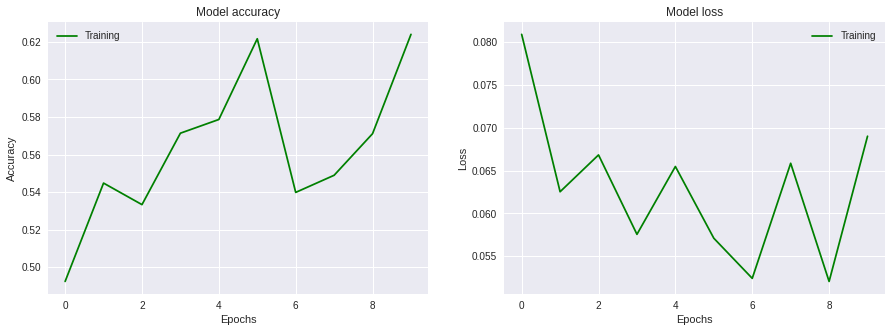

In [ ]:
plot_history(history)

# Model save

In [ ]:
model.save('dummy_model.hdf5')

model.load('dummy_model.hdf5')

In [ ]:
!apt-get install subversion
!svn checkout https://github.com/gosha20777/keras2cpp

In [ ]:
import keras2cpp

print(keras2cpp)